## Train Models With Azure Machine Learning
    (1) Create an experiment
    (2) Create or attach an existing compute target
    (3) Explore data
    (4) Display some sample images
    (5) Train on a remote cluster
    (6) Monitor a remote run
    (7) Register train model

In [2]:
# https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-train-models-with-aml
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.subscription_id, sep='\t')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Azure ML SDK Version:  1.3.0
Health-Metric	eastus	RG-NAM-EUS-ChatBot-Linux-Dev	e63ed021-5f7e-46e9-9ab2-c21f9ec78f0b


### (1) Create an experiment

In [3]:
from azureml.core import Experiment
experiment_name = 'sklearn-mnist'

exp = Experiment(workspace=ws, name=experiment_name)

### (2) Create or attach an existing compute target

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "Health-Metric-C1")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D1_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size=vm_size,
                                                                min_nodes=compute_min_nodes,
                                                                max_nodes=compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(
        ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(
        show_output=True, min_node_count=None, timeout_in_minutes=20)

    # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. Health-Metric-C1


### (3) Explore data

In [7]:
from azureml.core import Workspace, Dataset, Datastore

# create a TabularDataset from Titanic training data
local_path = os.path.join(os.getcwd(), 'data/Titanic3.csv')

# To create a dataset from an in memory pandas dataframe
#dataframe.to_csv(local_path)
workspace = Workspace(ws.subscription_id, ws.resource_group, ws.name)

# get the datastore to upload prepared data
datastore = workspace.get_default_datastore()

# upload the local file from src_dir to the target_path in datastore
datastore.upload(src_dir='data', target_path='data')

# create a dataset referencing the cloud location
dataset = Dataset.Tabular.from_delimited_files(datastore.path(os.path.join(os.getcwd(), 'data/Titanic3.csv')))

# create a new version of dataset
dataset = dataset.register(workspace = ws,
                           name = 'titanic_ds_new',
                           description = 'new titanic training data from local',
                           create_new_version = True)

Uploading an estimated of 1 files
Target already exists. Skipping upload for data/Titanic3.csv
Uploaded 0 files


DatasetValidationError: Cannot load any data from the specified path. Make sure the path is accessible and contains data.
The provided path is not valid or the files could not be accessed.(No files were found using path provided. Please make sure the path you've specified is correct, files exist and can be accessed.)|session_id=96240e2e-5d8e-495b-ad27-2cdb327adc33

In [8]:
from azureml.core import Dataset, Datastore

web_paths = ['https://dprepdata.blob.core.windows.net/demo/Titanic.csv',
             'https://dprepdata.blob.core.windows.net/demo/Titanic2.csv']
titanic_ds = Dataset.Tabular.from_delimited_files(path=web_paths)

# create a new version of titanic_ds
titanic_ds = titanic_ds.register(workspace = ws,
                                 name = 'titanic_ds',
                                 description = 'new titanic training data',
                                 create_new_version = True)

In [10]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data_folder')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

mnist_file_dataset = mnist_file_dataset.register(workspace=ws,
                                                 name='mnist_opendataset',
                                                 description='training and test dataset',
                                                 create_new_version=True)

### (4) Display some sample images

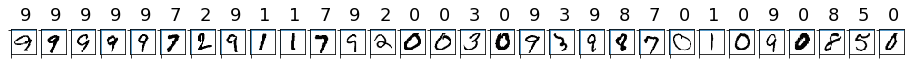

In [12]:
# make sure utils.py is in the same directory as this code
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(data_folder, "train-images-idx3-ubyte.gz"), False) / 255.0
X_test = load_data(os.path.join(data_folder, "t10k-images-idx3-ubyte.gz"), False) / 255.0
y_train = load_data(os.path.join(data_folder, "train-labels-idx1-ubyte.gz"), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, "t10k-labels-idx1-ubyte.gz"), True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize=(16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

### (5) Train on a remote cluster

In [1]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

env = Environment('Health-Metric-Env1')
cd = CondaDependencies.create(pip_packages=['azureml-sdk','scikit-learn==0.20.3','azureml-dataprep[pandas,fuse]>=1.1.14'])
env.python.conda_dependencies = cd

In [5]:
from azureml.train.sklearn import SKLearn
from azureml.opendatasets import MNIST

script_folder=os.path.join(os.getcwd(), "sklearn-mnist")
mnist_file_dataset = MNIST.get_file_dataset()
script_params = {
    '--data-folder': mnist_file_dataset.as_named_input('mnist_opendataset').as_mount(),
    '--regularization': 0.5
}

est = SKLearn(source_directory=script_folder,
              script_params=script_params,
              compute_target=compute_target,
              environment_definition=env, 
              entry_script='train.py')
run = exp.submit(config=est)
run.wait_for_completion(show_output=False)  # specify True for a verbose log

WARNING - If environment_definition or conda_dependencies_file_path is specified, Azure ML will not install any framework related packages on behalf of the user.
WARNING - Retrying (Retry(total=2, connect=3, read=3, redirect=None, status=None)) after connection broken by 'SSLError(SSLError("bad handshake: SysCallError(-1, 'Unexpected EOF')",),)': /history/v1.0/subscriptions/e63ed021-5f7e-46e9-9ab2-c21f9ec78f0b/resourceGroups/RG-NAM-EUS-ChatBot-Linux-Dev/providers/Microsoft.MachineLearningServices/workspaces/Health-Metric/experiments/sklearn-mnist/runs/sklearn-mnist_1587473773_40372f93


{'runId': 'sklearn-mnist_1587473773_40372f93',
 'target': 'Health-Metric-C1',
 'status': 'Finalizing',
 'startTimeUtc': '2020-04-21T13:13:30.077444Z',
 'warnings': [{'message': "This compute target type doesn't support non-Docker runs; overriding run configuration to enable Docker.\nPlease enable Docker in the environment section of your run configuration to stop seeing this warning message."}],
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '6631e996-3fc1-4469-9be6-babd1be93c65',
  'AzureML.DerivedImageName': 'azureml/azureml_cdb1a7b1b9154e0872c06b36dd1b72f4',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '0ea70020-c6a0-48ce-b9b0-c609563dc462'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'mnist_opendataset', 'mechanism': 'Mount'}}],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': ['--data-folder'

### (6) Monitor a remote run

In [6]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### (7) Register train model

In [7]:
print(run.get_file_names())

['azureml-logs/20_image_build_log.txt', 'azureml-logs/55_azureml-execution-tvmps_7a424a265af6fb6384a91446e3a9d7a579239cb511fde9946d1aa73086210c3e_d.txt', 'azureml-logs/65_job_prep-tvmps_7a424a265af6fb6384a91446e3a9d7a579239cb511fde9946d1aa73086210c3e_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_7a424a265af6fb6384a91446e3a9d7a579239cb511fde9946d1aa73086210c3e_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/123_azureml.log', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'outputs/sklearn_mnist_model.pkl']


In [8]:
# register model
model = run.register_model(model_name='sklearn_mnist',
                           model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

sklearn_mnist	sklearn_mnist:2	2
